train_images <class 'numpy.ndarray'> (60000, 28, 28) uint8


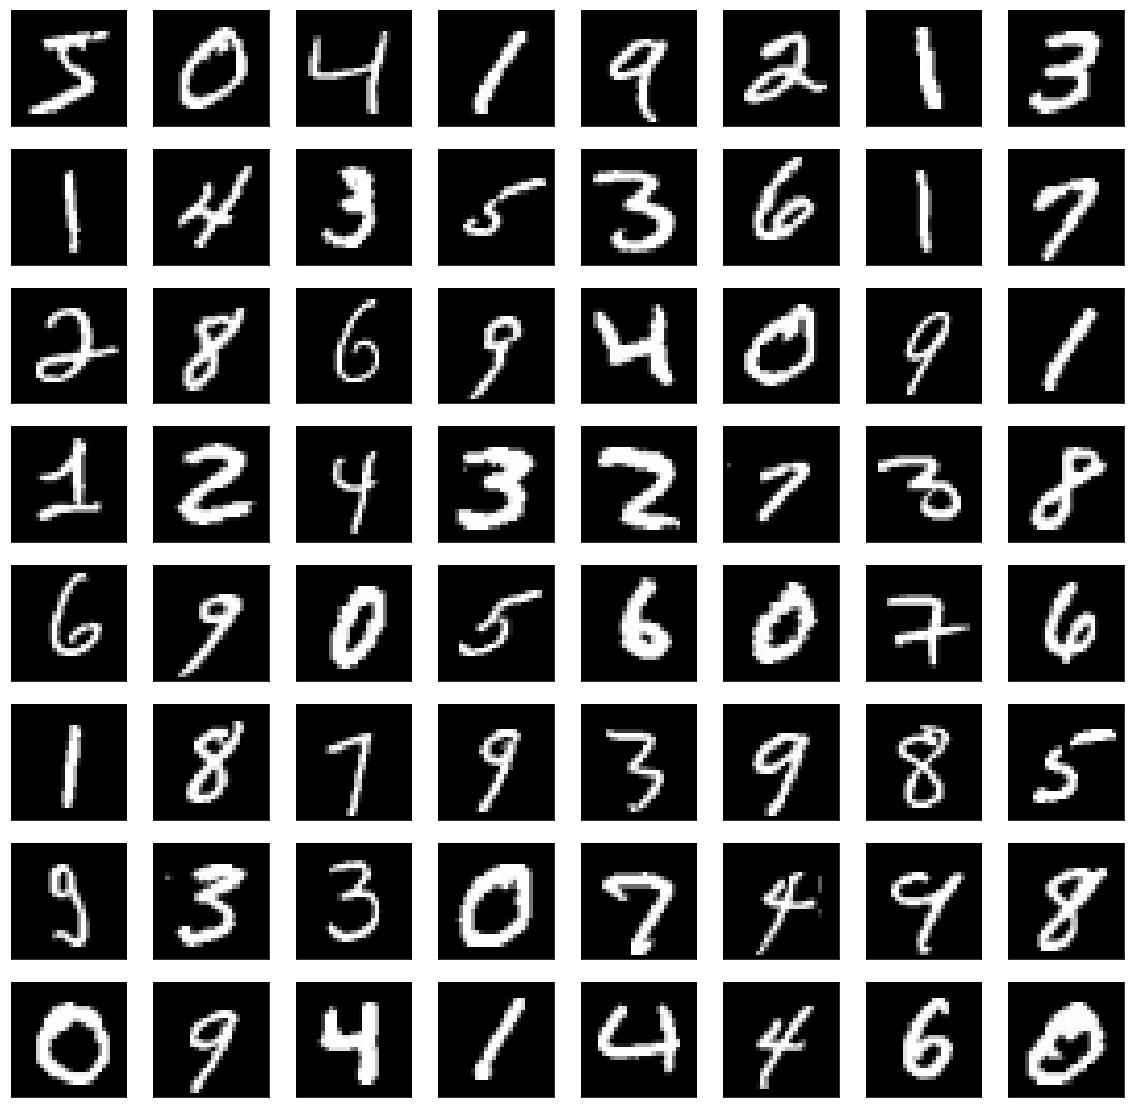

In [2]:
from keras import datasets, layers, models, utils, optimizers
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(train_images, _), (_, _) = datasets.mnist.load_data()

print( 'train_images', type(train_images), train_images.shape, train_images.dtype )

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( train_images[i], cmap="gray" )

In [3]:
_, H, W = train_images.shape
train_x = ( train_images.reshape(-1, H, W, 1) / 127.5 - 1 ).astype('float32')
print( 'train_x', type(train_x), train_x.shape, train_x.dtype )

train_x <class 'numpy.ndarray'> (60000, 28, 28, 1) float32


In [5]:
input_dim = 10
def gen_noise(batch_size):
    return np.random.uniform(-1, 1, (batch_size, input_dim))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 28, 28, 64)        0         
__________

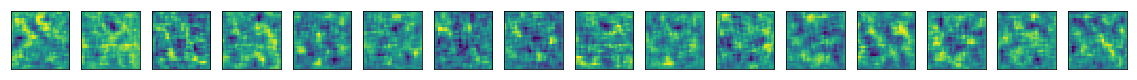

In [8]:
G = models.Sequential()

G.add( layers.Dense(7*7*128, input_dim=input_dim) )
G.add( layers.LeakyReLU(0.2) )
G.add( layers.Reshape((7, 7, 128)) )
G.add( layers.UpSampling2D(size=(2,2)) )
G.add( layers.Conv2D(64, kernel_size=(5,5), padding='same') )
G.add( layers.LeakyReLU(0.2) )
G.add( layers.UpSampling2D(size=(2,2)) )
G.add( layers.Conv2D(1, kernel_size=(5,5), padding='same', activation='tanh') )

G.summary()

generated = G.predict( gen_noise(16) )
plt.figure( figsize=(20,2) )

for i in range(16):
    plt.subplot(1,16,i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( generated[i].reshape((H,W)) )

In [11]:
D = models.Sequential()

D.add( layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(H,W,1)) )
D.add( layers.LeakyReLU(0.2) )
D.add( layers.Dropout(0.3) )
D.add( layers.Conv2D(128, (5,5), strides=(2,2), padding='same') )
D.add( layers.LeakyReLU(0.2) )
D.add( layers.Dropout(0.3) )
D.add( layers.Flatten() )
D.add( layers.Dense(1, activation='sigmoid') )

optimizer = optimizers.Adam(lr=0.0002, beta_1=0.5)
D.compile(optimizer=optimizer, loss='binary_crossentropy')

D.summary()

print( D.predict(generated[0:3]) )
print( D.predict(train_x[0:3]) )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
__________

In [12]:
GD = models.Sequential()
GD.add( G )
GD.add( D )

D.trainable = False
GD.compile( optimizer=optimizer, loss = 'binary_crossentropy' )
GD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         275457    
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 212865    
Total params: 488,322
Trainable params: 275,457
Non-trainable params: 212,865
_________________________________________________________________


In [ ]:
def train_D( real_images ):
    batch_size = real_images.shape[0]
    generated_images = G.predict( gen_noise(batch_size) )
    x = np.concatenate( (real_images, generated_images) )
    y = np.array( [1] * batch_size + [0] * batch_size )
    D.trainable = True
    D.train_on_batch(x, y)